In [3]:
IS_COLAB = False
try:
    import google.colab
    IS_COLAB = True
except:
    pass
if IS_COLAB:
    !pip install tensorflow-gpu
    !pip install jsonpickle

In [4]:
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
if IS_COLAB:
    %cd /content/drive/My\ Drive/MastersThesis
    !ls
    !pwd
    import sys
    sys.path.append('./')

/content/drive/My Drive/MastersThesis
 Autoencoderstart.ipynb   models.py
 callbacks.py		  named_constants.py
 config.py		  output_dir
 constants.py		  __pycache__
 datasets.py		  README.md
 experiments.py		  training_data.py
 for_training.ipynb	  training.py
 global_functions.py	  vizualizer.py
 model_combined.png	 'Vysledky Fashion mnist 22.10.2019 basic model.xlsx'
/content/drive/My Drive/MastersThesis


In [6]:
import global_functions
global_functions.on_start()

GPU OK


Using TensorFlow backend.


Experiment type Experiment classifier solo
Model index:  1
Parameters:  BasicTrainParametersClassifier(autoencoder_layers_trainable_during_classifier_training=True, batch_size=128, epochs=100, log_path=./output_dir/classifier_m.json, min_delta=1e-06, patience=20, save_weights=True, train_data_rate=0.1, validate=True)
Model name:  classifier
Stopped epoch:  62
Best epoch:  42
Value to monitor:  val_accuracy
Monitor best value:  0.9892
metric: accuracy
Values:  [0.6993333, 0.9061667, 0.93416667, 0.949, 0.959, 0.97066665, 0.97083336, 0.9735, 0.97783333, 0.98116666, 0.984, 0.984, 0.9855, 0.98483336, 0.989, 0.99, 0.98766667, 0.99116665, 0.9925, 0.991, 0.98966664, 0.9918333, 0.9913333, 0.9906667, 0.993, 0.9931667, 0.9943333, 0.9946667, 0.9941667, 0.9943333, 0.9945, 0.99516666, 0.9945, 0.9953333, 0.99366665, 0.99766666, 0.9971667, 0.99633336, 0.9943333, 0.9946667, 0.99633336, 0.99833333, 0.99666667, 0.996, 0.99583334, 0.99666667, 0.994, 0.99616665, 0.99483335, 0.9956667, 0.99633336, 0.997, 0.

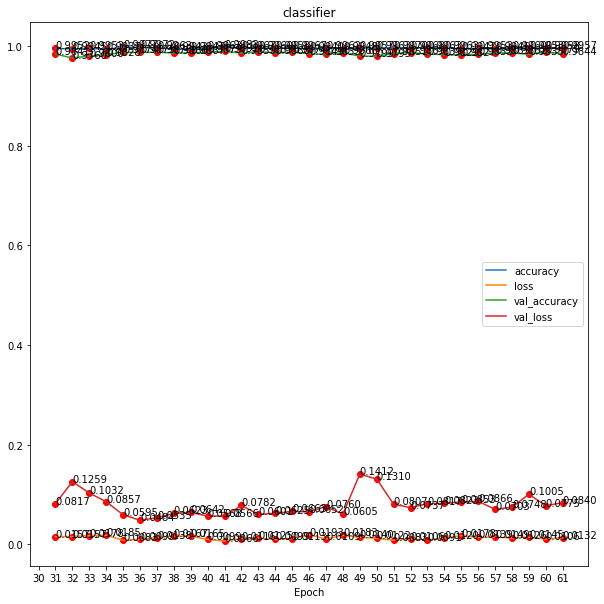

Experiment type Experiment classifier solo
Model index:  2
Parameters:  BasicTrainParametersClassifier(autoencoder_layers_trainable_during_classifier_training=True, batch_size=128, epochs=100, log_path=./output_dir/classifier_m.json, min_delta=1e-06, patience=20, save_weights=True, train_data_rate=0.25, validate=True)
Model name:  classifier
Stopped epoch:  54
Best epoch:  34
Value to monitor:  val_accuracy
Monitor best value:  0.992
metric: accuracy
Values:  [0.796, 0.94166666, 0.9626, 0.96653336, 0.97466666, 0.9786, 0.9792, 0.9826, 0.98333335, 0.9856, 0.986, 0.9853333, 0.98826665, 0.9892, 0.9892667, 0.9881333, 0.99233335, 0.9928667, 0.99233335, 0.9903333, 0.9928, 0.9946667, 0.9942, 0.9931333, 0.9924667, 0.9938, 0.9926, 0.995, 0.9943333, 0.9918, 0.99406666, 0.9935333, 0.99366665, 0.9964, 0.99546665, 0.9946, 0.995, 0.9944, 0.9952667, 0.9957333, 0.9960667, 0.9964, 0.9962, 0.9966, 0.99766666, 0.9972, 0.9972, 0.99693334, 0.99693334, 0.9962, 0.9961333, 0.9953333, 0.9961333, 0.9968]
metric:

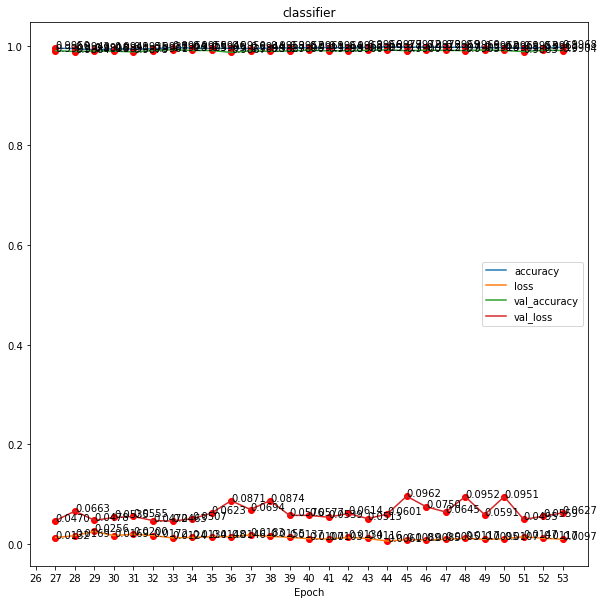

Experiment type Experiment classifier solo
Model index:  3
Parameters:  BasicTrainParametersClassifier(autoencoder_layers_trainable_during_classifier_training=True, batch_size=128, epochs=100, log_path=./output_dir/classifier_m.json, min_delta=1e-06, patience=20, save_weights=True, train_data_rate=0.5, validate=True)
Model name:  classifier
Stopped epoch:  78
Best epoch:  58
Value to monitor:  val_accuracy
Monitor best value:  0.9949
metric: accuracy
Values:  [0.8865333, 0.964, 0.9744667, 0.9799333, 0.98303336, 0.9849667, 0.9874333, 0.9880667, 0.9900333, 0.9906667, 0.99146664, 0.99086666, 0.9905667, 0.9924, 0.9928667, 0.9924, 0.9935667, 0.9949333, 0.99516666, 0.99303335, 0.9945667, 0.9949667, 0.99543333, 0.9952667, 0.9959667, 0.9952667, 0.99556667, 0.9952667, 0.9952, 0.99576664, 0.9964333, 0.9967667, 0.9961, 0.9951, 0.99586666, 0.9973, 0.99696666, 0.9976, 0.99616665, 0.9968333, 0.9971, 0.9979333, 0.99656665, 0.9975333, 0.9969, 0.9967667, 0.99736667, 0.9977, 0.99766666, 0.99693334, 0.99

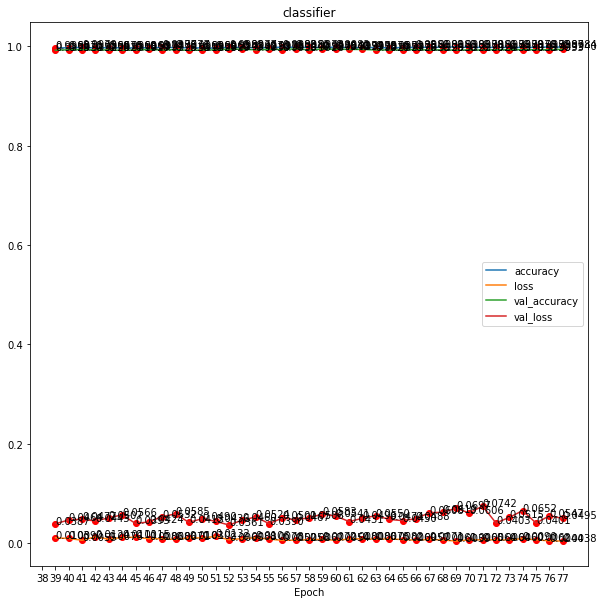

Experiment type Experiment classifier solo
Model index:  4
Parameters:  BasicTrainParametersClassifier(autoencoder_layers_trainable_during_classifier_training=True, batch_size=128, epochs=100, log_path=./output_dir/classifier_m.json, min_delta=1e-06, patience=20, save_weights=True, train_data_rate=1, validate=True)
Model name:  classifier
Stopped epoch:  61
Best epoch:  41
Value to monitor:  val_accuracy
Monitor best value:  0.9964
metric: accuracy
Values:  [0.9261, 0.97485, 0.9825, 0.9849667, 0.98836666, 0.98828334, 0.98941666, 0.9907, 0.9909, 0.99165, 0.9928833, 0.9926, 0.9932333, 0.99378335, 0.99373335, 0.9949333, 0.9945, 0.9946167, 0.9956, 0.99478334, 0.9960667, 0.996, 0.99583334, 0.99558336, 0.9960667, 0.99626666, 0.99618334, 0.9963167, 0.99658334, 0.99665, 0.9967667, 0.99663335, 0.9968333, 0.9973, 0.99701667, 0.99688333, 0.9967, 0.9971833, 0.99736667, 0.9974, 0.9975833, 0.9975, 0.99755, 0.99771667, 0.9974167, 0.9978167, 0.9975833, 0.9979333, 0.9977, 0.99785, 0.9978, 0.99808335, 0

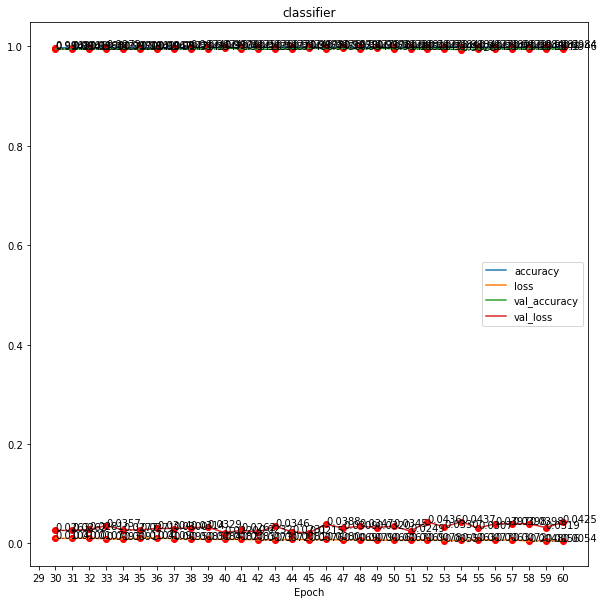

In [8]:
import vizualizer, experiments, constants, datasets

results = experiments.ExperimentBase.load_experiment_results(constants.ExperimentsPaths.Mnist.CLASSIFIER, False)
vizualizer.Vizualizer.vizualize([result.train_history for result in results], 0.5)


In [0]:
def make_batches(to_batch, batch_size = 128):
    return [to_batch[i * batch_size:(i + 1) * batch_size] for i in range((len(to_batch) + batch_size - 1) // batch_size )]

batch_size = 128
to_batch = tf.data.Dataset.from_tensor_slices((train_images, keras.utils.to_categorical(train_labels, 10) ))
train_batched = to_batch.batch(batch_size)

In [0]:
epochs = 10
for epoch in range(epochs):
    print("Epoch: {}", epoch)
    for step, (images, labels) in enumerate(train_batched):
        set_autoencoder_trainable(True)
        with tf.GradientTape() as tape:
          prediction = autoencoder(images)
          loss_autoencoder = autoencoder.loss(images, prediction)
          gradients = tape.gradient(loss_autoencoder, autoencoder.trainable_variables)
          autoencoder.optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))  
        set_autoencoder_trainable(False)
        with tf.GradientTape() as tape:
          predict_class = classifier(images)
          loss_classifier = classifier.loss(labels, predict_class)  
#           classiefier_trainable = classifier_head.trainable_variables
          classiefier_trainable = classifier.trainable_variables
          gradients = tape.gradient(loss_classifier, classiefier_trainable)
          classifier.optimizer.apply_gradients(zip(gradients  ,classiefier_trainable) ) 
          if step % 10 == 0:
              print("Step: {}, loss autoencoder: {}, loss classifier: {}".format(step, loss_autoencoder.numpy().mean(), loss_classifier.numpy().mean()))


In [0]:
for epoch in range(5):
  print("Classifier")
  historyClassifier = classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=128, epochs=1, validation_data= (test_images, test_labels_one_hot_encoding))

In [0]:
predictions_auto_encoder, predictions_classifier = auto_classifier.predict(test_images)
predictions_classifier = np.argmax(np.round(predictions_classifier),axis=1)
correct = np.where(predictions_classifier==test_labels)[0]
print( "Found {} correct labels".format(len(correct)))

In [0]:

test_eval = classifier.evaluate(test_images, test_labels_one_hot_encoding, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
predicted_classes = classifier.predict(test_images)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes = predicted_classes.astype('uint8')
correct = [predicted_classes[i] == value for i, value in enumerate(test_labels)]
print("Correct: {}".format( correct.count(True)))




In [0]:
predictions = autoencoder.predict(test_images)
# rand_start = np.random.randint(0, len(predictions) - 10)
# for i in range(rand_start, rand_start + 10):
#   plotImage(predictions[i].reshape(28, 28), "Predictions")
#   plotImage(test_images[i].reshape(28, 28), "Original")


num_images = 5
#np.random.seed(42)
random_test_images = np.random.randint(test_images.shape[0], size=num_images)

decoded_imgs = predictions


plt.figure(figsize=(28, 16))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.title("Original")
    plt.imshow(process_for_plotting(test_images[image_idx]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # # plot encoded image
    # ax = plt.subplot(3, num_images, num_images + i + 1)
    # plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(process_for_plotting(decoded_imgs[image_idx])) #reshape(28, 28)
    plt.title("Predicted")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:

from experiments import *
import jsonpickle
exp = ExperimentAutoencoder(DatasetProviderClass(FashionMnistDataset), basic_model_provider, generate_data_for_trainig)
exp.train(BasicTrainParameters(1, 128, True, 'mylog.json', True) )



In [0]:
from experiments import *
exp = ExperimentAutoencoder(DatasetProviderClass(FashionMnistDataset), basic_model_provider, generate_data_for_trainig)
# exp.train(BasicTrainParameters(1, 128, True, 'mylog.json', True) )
# exp.train(BasicTrainParameters(2, 128, True, 'mylog.json', True) )
train_result = exp.train(BasicTrainParameters(3, 128, True, 'mylog.json', True) )


In [0]:
exp_local = train_result[1]
exp_local

In [0]:
import experiments
import datasets
import importlib
importlib.reload(experiments)
for rate in [1]:
    exp = experiments.ExperimentAutoencoder(experiments.DatasetProviderClass(datasets.FashionMnistDataset), experiments.BasicModelProvider(), experiments.generate_data_for_trainig)
    exp.train(experiments.BasicTrainParametersOneModel(100, 128, 10, True, rate, 0.001, 'mylog.json', True))
    #exp.train(experiments.BasicTrainParametersOneModel(100, 128, True, rate, 'mylog.json', True))

In [0]:
import vizualizer
import experiments
import importlib
importlib.reload(vizualizer)
results = experiments.ExperimentBase.load_experiment_results('classifier.json')
vizualizer.Vizualizer.vizualize([result.train_history for result in results], 0.5)